In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import AutoMinorLocator

import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
import re

## Import Data

In [27]:
fnames = ['/Users/hkromer/02_PhD/02_Data/08.Microwave.PermanentMagnets/Messung01_magneticField.txt', '/Users/hkromer/02_PhD/02_Data/08.Microwave.PermanentMagnets/Messung02_magneticField.txt']

In [28]:
dfs = []
for fname in fnames:
    df = pd.read_csv(fname, skiprows=0, delimiter='\t')
    df.iloc[:,1] = df.iloc[:,1] * 1000 # convert to Gauss
    dfs.append(df)


## Plot

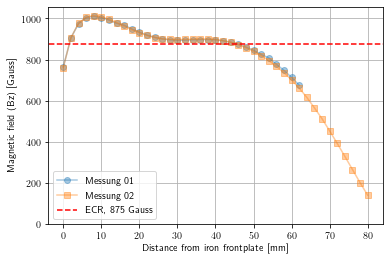

In [29]:
plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.4)

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='s', label='Messung 02', alpha=0.4)
xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

In [30]:
dfs[1]

,Abstand zur Frontscheibe in mm,Magnetfeld in kG
0,0,761.0
1,2,906.0
2,4,976.0
3,6,1006.0
4,8,1014.0
5,10,1008.0
6,12,996.0
7,14,980.0
8,16,962.0
9,18,945.0


# COMSOL Model
- Iron frontplate is at position 0 mm
- Plasma cup extends into the minus direction
- Data is in /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1000.1mmHole.csv and /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.03.relPermIron1000.1mmHole.csv
    - the data is for X {-100, 10, 1}, Y {-5, 5, 0.2}, Z {-5, 5, 0.2}
    - header: X,Y,Z, mfnc.normB (mT)
- From the manufacturer the magnetic flux density in the magnets is typically 1.10T, but certified to be higher than 1.03T
- Original simulation are in /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/03.undamaged.Br1.10.relPermIron1000.1mmHole_out.mph and /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/03.undamaged.Br1.03.relPermIron1000.1mmHole_out.mph

## Treat each y and z value separately
- for each x value find the minimum and maximum B field (depending on the y, z values)
- store in a new column
- plot this around the centerline (y=z=0)

## Transform

In the measurement the x=0mm is the frontplate, same is for the COMSOL. But in the COMSOL simulation the x goes in - direction, so everything has to be multiplied with -1.

The values at x =0 is not physical

## Take experimental error into account
- assumption is that ±1.5mm for the position for x<40 mm, and ±3mm for further away

In [31]:
fnames = ['/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.03.relPermIron1000.1mmHole.csv', '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1000.1mmHole.newIron.csv']
output_folder ='/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/Magnetic_fiel_measurement_simulation/'
dfs_comsol = []
dfs_comsol_maxmin = []
dfs_comsol_centerline = []
dfs_comsol_2mmline = []


def find_max_Bfield(df):
    mymax = df['normB_Gauss'].max()
    mymin = df['normB_Gauss'].min()
    return pd.Series({'normB_Gauss_max': mymax, 'normB_Gauss_min': mymin})


# load the files and append into a list of dataframes
for fname in fnames:
    df_comsol = pd.read_csv(fname, skiprows=8)
    df_comsol.columns = ['x', 'y', 'z', 'normB_mT']
    df_comsol['normB_Gauss'] = df_comsol['normB_mT'] * 10
    print(df_comsol.info())
    dfs_comsol.append(df_comsol)
    
    

    df_comsol = df_comsol.sort_values(by=['x'])


    df_comsol_maxmin = df_comsol.groupby('x').apply(lambda x: find_max_Bfield(x))
    # transform
    df_comsol_maxmin['x'] = df_comsol_maxmin.index * -1.0
    df_comsol_maxmin.set_index('x', inplace=True) 
    df_comsol_maxmin.drop([0.0, -1.0], inplace=True)
    dfs_comsol_maxmin.append(df_comsol_maxmin)
    print(df_comsol_maxmin.describe())
    
    df_comsol_centerline = df_comsol[ (df_comsol['y']==0) & (df_comsol['z']==0) ]
    df_comsol_centerline['x'] = df_comsol_centerline['x'] * -1.0
    df_comsol_centerline.set_index('x', inplace=True) 
    dfs_comsol_centerline.append(df_comsol_centerline)
    
    df_comsol_2mmline = df_comsol[ (df_comsol['y']==-5) & (df_comsol['z']==5) ]
    df_comsol_2mmline['x'] = df_comsol_2mmline['x'] * -1.0
    df_comsol_2mmline.set_index('x', inplace=True) 
    dfs_comsol_2mmline.append(df_comsol_2mmline)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288711 entries, 0 to 288710
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   x            288711 non-null  float64
 1   y            288711 non-null  float64
 2   z            288711 non-null  float64
 3   normB_mT     288711 non-null  float64
 4   normB_Gauss  288711 non-null  float64
dtypes: float64(5)
memory usage: 11.0 MB
None
       normB_Gauss_max  normB_Gauss_min
count       109.000000       109.000000
mean        678.151863       589.432516
std         589.715360       308.598964
min         128.095138         7.404984
25%         378.605960       305.399923
50%         779.556143       751.490501
75%         842.322969       828.443878
max        5986.501683       963.270936


<ipython-input-31-74808df1a382>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comsol_centerline['x'] = df_comsol_centerline['x'] * -1.0
<ipython-input-31-74808df1a382>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comsol_2mmline['x'] = df_comsol_2mmline['x'] * -1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288711 entries, 0 to 288710
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   x            288711 non-null  float64
 1   y            288711 non-null  float64
 2   z            288711 non-null  float64
 3   normB_mT     288711 non-null  float64
 4   normB_Gauss  288711 non-null  float64
dtypes: float64(5)
memory usage: 11.0 MB
None
       normB_Gauss_max  normB_Gauss_min
count       109.000000       109.000000
mean        722.963786       626.578205
std         625.639145       328.946911
min         139.076258         9.900607
25%         402.344926       318.154983
50%         830.901276       799.200468
75%         895.151143       880.241430
max        6333.157727      1097.471284


## Experiment and Simulation in comparison

In [32]:
smallerror = 1.5
bigerror = 3
def add_error(row, smallerror, bigerror):
    if row < 40:
        return pd.Series({'x_plus': row+smallerror, 'x_minus': row-smallerror})
    else:
        return pd.Series({'x_plus': row+bigerror, 'x_minus': row-bigerror})

    
a = dfs[1].iloc[:,0].apply(lambda x: add_error(x, smallerror, bigerror))
df_error = pd.concat([a, dfs[1]], axis=1)

In [33]:
# take error into account
from scipy.interpolate import interp1d
f1 = interp1d(df_error['x_plus'], df_error.iloc[:,3], kind='cubic', fill_value="extrapolate")
f2 = interp1d(df_error['x_minus'], df_error.iloc[:,3], kind='cubic', fill_value="extrapolate")

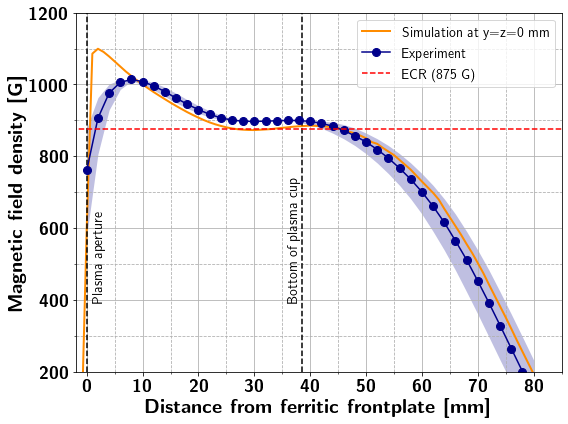

In [34]:
import os, matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

fig = plt.figure(figsize=(8,6))
fs = 20
# plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.75)



plt.plot(dfs_comsol_centerline[1].index, dfs_comsol_centerline[1].loc[:,'normB_Gauss'], color='darkorange', label='Simulation at y=z=0 mm',  linewidth=2)
plt.plot([38.5, 38.5], [200, 1200], '--', color='black')
plt.plot([0, 0], [200, 1200], '--', color='black')
# plt.plot(dfs_comsol_2mmline[1].index, dfs_comsol_2mmline[1].loc[:,'normB_Gauss'], color='darkred', label='Simulation, 1.10 T 2mm line',  linewidth=1)
# plt.plot(dfs_comsol_centerline[0].index, dfs_comsol_centerline[0].loc[:,'normB_Gauss'], color='darkgreen', label='Simulation 1.03 T centerline',  linewidth=1)
# plt.plot(dfs_comsol_maxmin[1].index, dfs_comsol_maxmin[1].loc[:,'normB_Gauss_min'], color='darkred', label='Simulation 1.10 T max',  linewidth=1)
# plt.plot(dfs_comsol_maxmin[0].index, dfs_comsol_maxmin[0].loc[:,'normB_Gauss_min'], color='darkorange', label='Simulation 1.03 T min',  linewidth=1)
# plt.fill_between(dfs_comsol_maxmin[0].index, dfs_comsol_maxmin[1].loc[:,'normB_Gauss_min'], dfs_comsol_maxmin[0].loc[:,'normB_Gauss_min'], alpha=0.3,color='darkred')

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='o', color='darkblue', markeredgecolor='darkblue', markersize=8, label='Experiment')
plt.fill_between(dfs[1].iloc[:,0], f1(dfs[1].iloc[:,0]), f2(dfs[1].iloc[:,0]), alpha=0.25, color='darkblue', linewidth=0)


xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR (875 G)')
plt.legend(fontsize=fs-6)
plt.grid()
plt.xlabel(r'\textbf{Distance from ferritic frontplate [mm]}', fontsize=fs, labelpad=2)
plt.ylabel(r'\textbf{Magnetic field density [G]}', fontsize=fs, labelpad=2)
ylim = plt.gca().get_ylim()
plt.gca().tick_params('x', colors='black', labelsize=fs-2)	
plt.gca().tick_params('y', colors='black', labelsize=fs-2)
plt.text(36, 400, 'Bottom of plasma cup', fontsize=14, rotation=90)
plt.text(1, 400, 'Plasma aperture', fontsize=14, rotation=90)
ax = plt.gca()
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)

ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.ylim(200, 1200)
plt.xlim(-2,85)
plt.tight_layout()
plt.savefig(f'{output_folder}Magnetic_fiel_measurement_simulation.pdf', dpi=900)
plt.show()

# Plot with new simulation

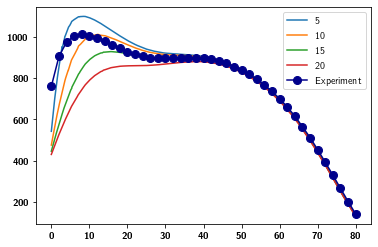

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
d_df = {}
for v in [5, 10, 15, 20]:
    f = f'/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/sweep_hole_{v}.txt'
    df = pd.read_csv(f, delimiter=r'\s+', skiprows=9, header=None)
    df.columns = ['x', 'y', 'z', 'normB_G']
    df = df.sort_values(by='x')
    df['x'] = np.abs(df['x'])
    df = df[df['x'] <= 80]
    d_df[v] = df
    
for k, df in d_df.items():
    plt.plot(df['x'].values, df['normB_G'].values, label=k)
plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='o', color='darkblue', markeredgecolor='darkblue', markersize=8, label='Experiment')
  
plt.legend()
plt.show()

## Plot

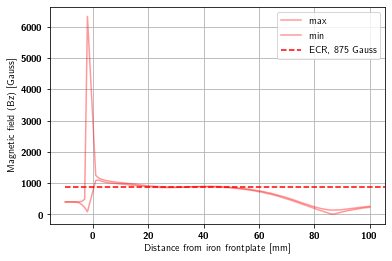

In [10]:
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], color='red', label='max', alpha=0.4)
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], color='red', label='min', alpha=0.4)

xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

# plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

## Experiment and Simulation in comparison

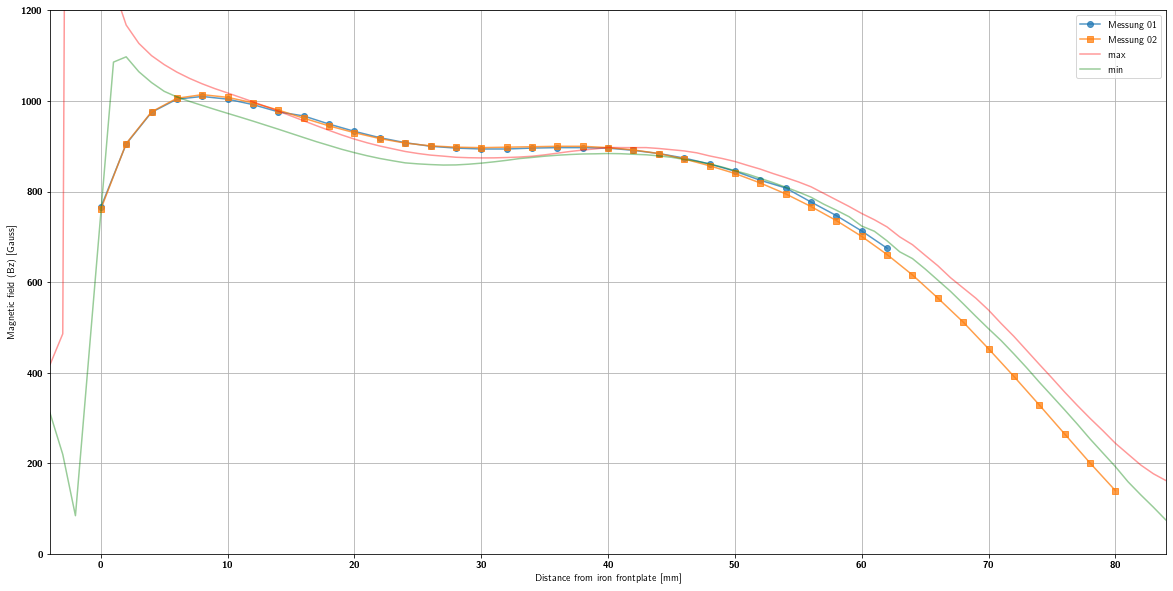

In [11]:
plt.figure(figsize=(20,10))
plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.75)

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='s', label='Messung 02', alpha=0.75)

xlim = plt.gca().get_xlim()
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], color='red', label='max', alpha=0.4)
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], color='green', label='min', alpha=0.4)
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(0, 1200)
plt.xlim(xlim)
plt.show()

## compare different relative iron plate values

In [12]:
path = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/'
fnames = os.listdir(path)
fnames = [f'{path}{f}' for f in fnames if f.endswith('csv')]
fnames

['/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1200.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1600.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron800.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1800.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1000.1mmHole.newIron.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.03.relPermIron1000.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1000.1mmHole.csv']

In [13]:
dfs = []
def find_max_Bfield(df):
    mymax = df['normB_Gauss'].max()
    mymin = df['normB_Gauss'].min()
    return pd.Series({'normB_Gauss_max': mymax, 'normB_Gauss_min': mymin})

for fname in fnames:
    ID = re.findall(r'Iron(\d+)\.', fname)[0]
    df_comsol = pd.read_csv(fname, skiprows=8)
    df_comsol.columns = ['x', 'y', 'z', 'normB_mT']
    df_comsol['normB_Gauss'] = df_comsol['normB_mT'] * 10
    df_comsol = df_comsol.sort_values(by=['x'])

    df_comsol_maxmin = df_comsol.groupby('x').apply(lambda x: find_max_Bfield(x))
    df_comsol_maxmin['ID'] = ID
    dfs.append(df_comsol_maxmin)

In [14]:
for df_comsol_maxmin in dfs:
    ID = df_comsol_maxmin.ID.unique()[0]
    plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], label=f'{ID}_max', alpha=0.4)

xlim = plt.gca().get_xlim()
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

# plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

RuntimeError: latex was not able to process the following string:
b'1200_max'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/hkromer/.matplotlib/tex.cache/0aa4a195047871816d1b559039ed49d0.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2018/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./0aa4a195047871816d1b559039ed49d0.aux)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...size{10.000000}{12.500000}{\sffamily 1200_
                                                  max}
No pages of output.
Transcript written on 0aa4a195047871816d1b559039ed49d0.log.




<Figure size 432x288 with 1 Axes>

In [15]:
for df_comsol_maxmin in dfs:
    ID = df_comsol_maxmin.ID.unique()[0]
    plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], label=f'{ID}_min', alpha=0.4)

xlim = plt.gca().get_xlim()
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

plt.ylim(915,917)
plt.xlim(xlim)
plt.show()

RuntimeError: latex was not able to process the following string:
b'1200_min'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/hkromer/.matplotlib/tex.cache/97bbd72dabd12f52122d9a5a30386990.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2018/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/sfmath/sfmath.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./97bbd72dabd12f52122d9a5a30386990.aux)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...size{10.000000}{12.500000}{\sffamily 1200_
                                                  min}
No pages of output.
Transcript written on 97bbd72dabd12f52122d9a5a30386990.log.




<Figure size 432x288 with 1 Axes>